# Impact of news on stock 

## Introduction:
This project is the Capstone project for Udacity course Data Scientist Nanodegree. The objective here is to find the impact of the news on stock movements. It worth mentioning that Kaggle also is running a similar competition, and this project is not relevant to that by no means. Neither the data nor the algorithms.

## project structure:
This project has three major components:

- **Scraping news:**
    For this purpose, Scrappy library is used in petrel. Every 1 hour a Crontab job automatically reads news from few news pages.
    
- **prediction using ML algorithms:**
    Current note book shows some fundamental ML approaches, that I had taken in in order to come up with a reasonable model.
    
- **Serving the results in a backend server:**
    The data is stored in a Linux based virtual private server, using Django Rest Framework.


## Project results
The final back can be found in the following url:

http://142.93.32.119/api/

it contains two endpoints; **news** in which news has been stored. Here *up* and *down* fields actually are the probability prediction of the ML model (developed in this notebook) based on the news content. For example, "up"=0.6 means that the news content is 60% likely to be a positive news associated with increasing stock.

The other endpoint **entity** where the entities of each news has been stored for statistical purposes.

## Developing Machine learning model

Before starting the modeling, I should mention that bellow is analysis on two different data set. First data set has taken much more effort to collect but, results are not so good. second model gives better results and that is the model which is currently deployed in backend.

## Dataset #1

### 0- Importing required  data

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words("english")
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit,learning_curve

### 1- Data import
This data has been scraped from many different sourses and has been put together. For the sake of briviet I skiped all different data processings as it will overwhelm the note book.

In [2]:
alldata=pd.read_csv("Alpha_stock_indicators_sectors.csv",index_col=0)

In [3]:
alldata.columns

Index(['sym', 'title1', 'newstime', 'desc', 'newstime2', 'yesterdayHigh',
       'yesterdayLow', 'yesterdayOpen', 'yesterdayClose', 'yesterdayVolume',
       'yesterdayAdjClose', 'nextdayHigh', 'nextdayLow', 'nextdayOpen',
       'nextdayClose', 'nextdayVolume', 'nextdayAdjClose', 'sector',
       'industry', 'SPchangeHigh', 'SPchangeLow', 'SPchangeOpen',
       'SPchangeClose', 'SPchangeVolume', 'SPchangeAdjClose', 'DJIchangeHigh',
       'DJIchangeLow', 'DJIchangeOpen', 'DJIchangeClose', 'DJIchangeVolume',
       'DJIchangeAdjClose', 'IXICchangeHigh', 'IXICchangeLow',
       'IXICchangeOpen', 'IXICchangeClose', 'IXICchangeVolume',
       'IXICchangeAdjClose', 'N225changeHigh', 'N225changeLow',
       'N225changeOpen', 'N225changeClose', 'N225changeVolume',
       'N225changeAdjClose', 'GoldchangeHigh', 'GoldchangeLow',
       'GoldchangeOpen', 'GoldchangeClose', 'GoldchangeVolume',
       'GoldchangeAdjClose', 'OilchangeHigh', 'OilchangeLow', 'OilchangeOpen',
       'OilchangeClose',

In [4]:
alldata.head()

,sym,title1,newstime,desc,newstime2,yesterdayHigh,yesterdayLow,yesterdayOpen,yesterdayClose,yesterdayVolume,...,GoldchangeOpen,GoldchangeClose,GoldchangeVolume,GoldchangeAdjClose,OilchangeHigh,OilchangeLow,OilchangeOpen,OilchangeClose,OilchangeVolume,OilchangeAdjClose
0,TROW,T. Rowe Price sells most of its Tesla shares,"Wed, May 15, 10:47 PM",T. Rowe Price (NASDAQ:TROW) sold more than 80%...,2019-05-15 22:47:00,104.559998,101.989998,102.059998,103.959999,928100.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
1,GCI,Gannett to retain all seats in MNG proxy fight...,"Wed, May 15, 10:33 PM",Gannett (NYSE:GCI) looks likely to retain all ...,2019-05-15 22:33:00,8.915000,8.650000,8.720000,8.870000,722100.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
2,XPO,"XPO shareholders support exec pay plan, reject...","Wed, May 15, 10:29 PM",XPO Logistics' (NYSE:XPO) shareholders have ra...,2019-05-15 22:29:00,58.580002,56.279999,57.150002,58.360001,1333600.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
3,MGNX,MacroGenics +13.1% on new data from breast can...,"Wed, May 15, 6:53 PM",MacroGenics (NASDAQ:MGNX) is up 13.1% in postm...,2019-05-15 18:53:00,16.400000,15.240000,16.400000,16.270000,2031600.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107
4,BG,"Bunge looks to downsize before growing again, ...","Wed, May 15, 6:48 PM",New Bunge (NYSE:BG) CEO Greg Heckman says the ...,2019-05-15 18:48:00,53.650002,52.389999,52.490002,53.270000,998200.0,...,0.000897,-0.000572,0.853672,-0.000572,0.005362,-0.003972,-0.006025,0.009107,-0.738832,0.009107


#### Brief Data explanation

sym: company sumbol

**title**: title news about the company

**newstim**: time of the news

**desc**: news content

**newstime2**: standardizing all the dates

**yesterdayHigh**:High pricefor day before news

**yesterdayLow**: Low pricefor day before news

**yesterdayOpen**:Open price for day before news

**yesterdayClose**: Close price for day before news

**yesterdayVolume**:Volume for day before news

**yesterdayAdjClose**: AdjClose for day before news

**nextdayHigh**: High price for day after news

**nextdayLow**: Low price for day after news

**nextdayOpen**:Open price for day after news

**nextdayClose**:Close price for day after news

**nextdayVolume**: Volume for day after news

**nextdayAdjClose**:Close price for day after news 

**sector**: sector that company belongs to


on the list bellow there are opening, closing high,low, volume, adjclose  changes for price for
SP: S&P500

**DJI: Dow Jones Industrial Average**

**IXIC:NASDAQ Composite**

**N225: Nikkei 225**

**Oil: oil price**

**Gold: Gold price**



'industry', 'SPchangeHigh', 'SPchangeLow', 'SPchangeOpen',
'SPchangeClose', 'SPchangeVolume', 'SPchangeAdjClose', 'DJIchangeHigh',
'DJIchangeLow', 'DJIchangeOpen', 'DJIchangeClose', 'DJIchangeVolume',
'DJIchangeAdjClose', 'IXICchangeHigh', 'IXICchangeLow',
'IXICchangeOpen', 'IXICchangeClose', 'IXICchangeVolume',
'IXICchangeAdjClose', 'N225changeHigh', 'N225changeLow',
'N225changeOpen', 'N225changeClose', 'N225changeVolume',
'N225changeAdjClose', 'GoldchangeHigh', 'GoldchangeLow',
'GoldchangeOpen', 'GoldchangeClose', 'GoldchangeVolume',
'GoldchangeAdjClose', 'OilchangeHigh', 'OilchangeLow', 'OilchangeOpen',
'OilchangeClose', 'OilchangeVolume', 'OilchangeAdjClose',



In [5]:
alldata.shape

(45449, 55)

In [6]:
alldata.dropna(inplace=True)
alldata.shape

(33622, 55)

In [7]:
alldata.isnull().sum()

sym                   0
title1                0
newstime              0
desc                  0
newstime2             0
yesterdayHigh         0
yesterdayLow          0
yesterdayOpen         0
yesterdayClose        0
yesterdayVolume       0
yesterdayAdjClose     0
nextdayHigh           0
nextdayLow            0
nextdayOpen           0
nextdayClose          0
nextdayVolume         0
nextdayAdjClose       0
sector                0
industry              0
SPchangeHigh          0
SPchangeLow           0
SPchangeOpen          0
SPchangeClose         0
SPchangeVolume        0
SPchangeAdjClose      0
DJIchangeHigh         0
DJIchangeLow          0
DJIchangeOpen         0
DJIchangeClose        0
DJIchangeVolume       0
DJIchangeAdjClose     0
IXICchangeHigh        0
IXICchangeLow         0
IXICchangeOpen        0
IXICchangeClose       0
IXICchangeVolume      0
IXICchangeAdjClose    0
N225changeHigh        0
N225changeLow         0
N225changeOpen        0
N225changeClose       0
N225changeVolume

## 2- Tagging data
here we find out difference of the price on day before and after and call it *nextHigh-yestHigh*

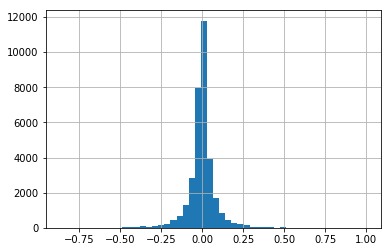

In [8]:
alldata["nextHigh-yestHigh"]=alldata["nextdayHigh"]/alldata["yesterdayHigh"]-1
alldata=alldata[alldata["nextHigh-yestHigh"]<1]
alldata["nextHigh-yestHigh"].hist(bins=50)

if price is increased (positive), then give it "buy" tag, otherwise "sell" tag

In [9]:
def tagmaker2(x):
    if x>0:
        return "up"
    else :
        return "down"
alldata["tag"]=alldata["nextHigh-yestHigh"].apply(lambda x:tagmaker2(x))
alldata["tag"].value_counts()

down    17141
up      16412
Name: tag, dtype: int64

## 3- defining required functions

In [10]:
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def display_results(y_test, y_pred):
    '''
    function to display confusion matrix
    '''
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    df=pd.DataFrame(metrics.confusion_matrix(y_test,y_pred),index=labels,columns=labels)
    return df

## 4- defining features and targets

In [11]:
alldata['desc-title']=alldata['title1']+" "+alldata['desc']
features=alldata[['desc-title','SPchangeHigh',"OilchangeHigh", 'GoldchangeHigh','IXICchangeHigh', 'DJIchangeHigh','N225changeHigh','sector']]
target=alldata['tag']
X_train, X_test, y_train, y_test = train_test_split(features,target,  random_state=444,test_size=.2)
print('rows in the original data set: {}'.format(alldata.shape[0]))
print('rows in the training set: {}'.format(X_train.shape[0]))
print('rows in the test set: {}'.format(X_test.shape[0]))

rows in the original data set: 33553
rows in the training set: 26842
rows in the test set: 6711


In [12]:
features.head(5)

,desc-title,SPchangeHigh,OilchangeHigh,GoldchangeHigh,IXICchangeHigh,DJIchangeHigh,N225changeHigh,sector
0,T. Rowe Price sells most of its Tesla shares T...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Finance
1,Gannett to retain all seats in MNG proxy fight...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Services
2,"XPO shareholders support exec pay plan, reject...",0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Services
3,MacroGenics +13.1% on new data from breast can...,0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Health Care
4,"Bunge looks to downsize before growing again, ...",0.002152,0.005362,0.000897,0.00804,0.001399,0.005411,Consumer Non-Durables


In [13]:
target.head(5)

0      up
1    down
2      up
3      up
4    down
Name: tag, dtype: object

## 5- preprocessing pipeline

In [14]:
preprocess = make_column_transformer(
    (make_pipeline( CountVectorizer(tokenizer=tokenize),TfidfTransformer()),'desc-title'),
    (StandardScaler(),['SPchangeHigh',"OilchangeHigh", 'GoldchangeHigh','IXICchangeHigh', 'DJIchangeHigh']),
    (OneHotEncoder(),['sector']),
)
a=preprocess.fit_transform(features)

## 6- model pipeline

In [15]:
def model_pipeline():
    pipeline = Pipeline([
        ('process', preprocess),
        
#         ('clf', RandomForestClassifier(random_state = 42))
        ('clf', GradientBoostingClassifier())
#         ('clf', MultinomialNB())
    ])
    return pipeline


X_train.shape
y_train.shape

(26842,)

## 7- fit model

In [16]:
model = model_pipeline()
model.fit(X_train, y_train);

## 8- how model is doing

In [17]:
predictions = model.predict(X_test)
predictions 

array(['up', 'up', 'down', ..., 'down', 'up', 'down'], dtype=object)

In [18]:
display_results(y_test, predictions)

Labels: ['down' 'up']
Confusion Matrix:
 [[2095 1370]
 [1195 2051]]
Accuracy: 0.6177916852928028


,down,up
down,2095,1370
up,1195,2051


In [19]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

        down       0.64      0.60      0.62      3465
          up       0.60      0.63      0.62      3246

    accuracy                           0.62      6711
   macro avg       0.62      0.62      0.62      6711
weighted avg       0.62      0.62      0.62      6711



In [20]:
# probabilities
predictions = model.predict_proba(X_test)
predictions 

array([[0.47697237, 0.52302763],
       [0.38396097, 0.61603903],
       [0.51146156, 0.48853844],
       ...,
       [0.52346677, 0.47653323],
       [0.32417557, 0.67582443],
       [0.5579455 , 0.4420545 ]])

# Dataset #2
This data sect includes just title and body

## 9- data import

In [21]:
fooldata=pd.read_csv("fool.csv")

In [22]:
fooldata.head()

,title,price
0,Why Williams-Sonoma Stock Popped Today,Shares of were up 11% as of 12:00 p.m. EDT F...
1,Why Tailored Brands Stock Dropped 10.5%,Shares of Men's Wearhouse owner stock on Fri...
2,Here's Why Mattel Inc Stock Fell Today,Shares of are down 5.9% at 1:50 p.m. on May 3...
3,Why Dell Technologies Stock Fell Friday,Shares of information technology and computer ...
4,Why Pitney Bowes Stock Dropped 11% on Friday,"It's Friday, and shares of postal solutions pr..."


In [23]:
fooldata = fooldata.rename(columns={'price': 'desc'})

## 10- Tagging data based on keywords in the title

In [24]:
def addTag(str):
    '''
    function to return up or down based if
    a string exists in another string
    '''
    if "Crashing" in str:
        return "down"
    if "Got Whacked" in str:
        return "down"
    if "Lower" in str:
        return "down"
    elif "Crashed" in str:
        return "down"
    elif "Lost" in str:
        return "down"
    elif "Crushed" in str:
        return "down"
    elif "Slumped" in str:
        return "down"
    elif "Pop" in str:
        return "up"
    elif "Dropped" in str:
        return "down"
    elif "Drop" in str:
        return "down"
    elif "Fell" in str:
        return "down"
    elif "Fall" in str:
        return "down"
    elif "Fallen" in str:
        return "down"
    elif "Sank" in str:
        return "down"
    elif "Destroyed" in str:
        return "down"
    elif "Tumbling" in str:
        return "down"
    elif "Tumbled" in str:
        return "down"
    elif "Plunged" in str:
        return "down"
    elif "Plunging" in str:
        return "down"
    elif "Plummeted" in str:
        return "down"
    elif "Surge on Debt" in str:
        return "down"
    elif "Down" in str:
        return "down"
    elif "Slipping" in str:
        return "down"
    elif "Slipped" in str:
        return "down"
    elif "Surged" in str:
        return "down"
    elif "Lower" in str:
        return "down"
    elif "Crash" in str:
        return "down"
    elif "Tanking" in str:
        return "down"
    elif "Out of Fashion" in str:
        return "down"
    elif "Sinking" in str:
        return "down"
    elif "Tanking" in str:
        return "down"
    elif "Hammered" in str:
        return "down"
    elif "Hammerring" in str:
        return "down"
    elif "Slammed" in str:
        return "down"
    elif "Slamming" in str:
        return "down"
    elif "Imploding" in str:
        return "down"
    elif "Cratered" in str:
        return "down"
    elif "Cratering" in str:
        return "down"
    elif "Sliding" in str:
        return "down"
    elif "Roller Coaster" in str:
        return "down"
    elif "Were Down" in str:
        return "down"
    elif "Dove" in str:
        return "down"
    elif "in the Doghouse" in str:
        return "down"
    elif "Slumping" in str:
        return "down"
    elif "Slumped" in str:
        return "down"
    elif "Collapsing" in str:
        return "down"
    elif "Collapsed" in str:
        return "down"
    elif "Getting Walloped" in str:
        return "down"
    elif "Mauled" in str:
        return "down"
    elif "Tanked" in str:
        return "down"
    elif "Fizzled" in str:
        return "down"
    elif "Plummeting" in str:
        return "down"
    elif "Stumbled" in str:
        return "down"
    elif "Smashed" in str:
        return "down"
    elif "Slid" in str:
        return "down"
    elif "Rough Day" in str:
        return "down"
    elif "Slides" in str:
        return "down"
    elif "Under Pressure" in str:
        return "down"
    elif "Shrugged Off" in str:
        return "down"
    elif "Declined" in str:
        return "down"
    elif "Fading" in str:
        return "down"
    elif "Sink" in str:
        return "down"
    elif "Moving in Opposite Directions" in str:
        return "down"
    elif "Hit the Skids" in str:
        return "down"
    elif "Dip" in str:
        return "down"
    elif "Broke Out" in str:
        return "down"
    elif "Setback" in str:
        return "down"
    elif "Caught Fire" in str:
        return "down"
    elif "Buckled" in str:
        return "down"
    elif "Lose" in str:
        return "down"
    elif "Gave Back Its Gains" in str:
        return "down"
    elif "Got Dumped" in str:
        return "down"
    elif "Weighed on" in str:
        return "down"
    elif "Getting Thrashed" in str:
        return "down"
    elif "Tank" in str:
        return "down"
    elif "Tumble" in str:
        return "down"
    elif "Taking a Beating" in str:
        return "down"
    elif "Derailed" in str:
        return "down"
    elif "Plunge" in str:
        return "down"
    elif "Stumbling" in str:
        return "down"
    elif "Imploded" in str:
        return "down"
    elif "Losing" in str:
        return "down"
    elif "Nosediving" in str:
        return "down"
    elif "Bad Day" in str:
        return "down"


    elif "Soared" in str:
        return "up"
    elif "Looks Gorgeous" in str:
        return "up"
    elif "Leapt" in str:
        return "up"
    elif "Leaping" in str:
        return "up"
    elif "Soars" in str:
        return "up"
    elif "Soaring" in str:
        return "up"
    elif "Jumped" in str:
        return "up"
    elif "Climbed" in str:
        return "up"
    elif "Rose" in str:
        return "up"
    elif "Rising" in str:
        return "up"
    elif "Gained" in str:
        return "up"
    elif "Skyrocketed" in str:
        return "up"
    elif "Skyrocketing" in str:
        return "up"
    elif "Rocketed" in str:
        return "up"
    elif "Upswing" in str:
        return "up"
    elif "Popped" in str:
        return "up"
    elif "Are Up" in str:
        return "up"
    elif "Are Higher" in str:
        return "up"
    elif "Took Off" in str:
        return "up"
    elif "Climbing" in str:
        return "up"
    elif "Spiked" in str:
        return "up"
    elif "Heating Up" in str:
        return "up"
    elif "Gaining" in str:
        return "up"
    elif "Surging" in str:
        return "up"
    elif "Trading Higher" in str:
        return "up"
    elif "Flying Higher" in str:
        return "up"
    elif "Were Up" in str:
        return "up"
    elif "Moving Higher" in str:
        return "up"
    elif "Jumping" in str:
        return "up"
    elif "Higher" in str:
        return "up"
    elif "Is on the Move" in str:
        return "up"
    elif "on the Rise" in str:
        return "up"
    elif "Accelerating" in str:
        return "up"
    elif "Soar" in str:
        return "up"
    elif "Doubled" in str:
        return "up"
    elif "Doubling" in str:
        return "up"
    elif "Took a Hit" in str:
        return "up"
    elif "Up" in str:
        return "up"
    elif "Took Flight" in str:
        return "up"
    elif "Rebounded" in str:
        return "up"
    elif "Rallied" in str:
        return "up"
    elif "Leaped" in str:
        return "up"
    elif "Advanced" in str:
        return "up"
    elif "Bounced" in str:
        return "up"

    elif "Is On Fire" in str:
        return "up"
    elif "Jump" in str:
        return "up"
    elif "Hit the Sky" in str:
        return "up"
    elif "Skyrocket" in str:
        return "up"
    elif "Rallying" in str:
        return "up"
    elif "Got Cut in Half" in str:
        return "down"
    elif "Hit Vail" in str:
        return "down"
    elif "Obliterated" in str:
        return "down"
    elif "Decline" in str:
        return "down"
    elif "Swooned" in str:
        return "down"
    elif "Struggled" in str:
        return "down"
    elif "Crushing" in str:
        return "down"

    elif "Roaring" in str:
        return "up"
    elif "Rally" in str:
        return "up"
    elif "Rise" in str:
        return "up"
    elif "Rebounding" in str:
        return "up"
    elif "Bouncing Back" in str:
        return "up"
    elif "Good Day" in str:
        return "up"
    elif "Making Gains" in str:
        return "up"
    elif "Got a Lift" in str:
        return "up"
    elif "Spiking" in str:
        return "up"
    elif "Surge" in str:
        return "up"
    elif "Accelerates" in str:
        return "up"
    elif "Rocketing" in str:
        return "up"
    elif "Ascend" in str:
        return "up"
    elif "Cheering" in str:
        return "up"
    elif "Surge" in str:
        return "up"

fooldata["tag"]=fooldata["title"].apply(lambda x:addTag(x) )
fooldata.isnull().sum()


title       0
desc      159
tag      1175
dtype: int64

In [25]:
fooldata.dropna(inplace=True,axis=0)
fooldata.isnull().sum()

title    0
desc     0
tag      0
dtype: int64

In [26]:
fooldata.shape

(14267, 3)

In [27]:
fooldata["tag"].value_counts()

up      7518
down    6749
Name: tag, dtype: int64

In [28]:
fooldata.columns

Index(['title', 'desc', 'tag'], dtype='object')

## 11- defining features and targets

In [29]:
features=fooldata["desc"]
target=fooldata['tag']
X_train, X_test, y_train, y_test = train_test_split(features,target,random_state=222,test_size=.2)
print('rows in the original data set: {}'.format(fooldata.shape[0]))
print('rows in the training set: {}'.format(X_train.shape[0]))
print('rows in the test set: {}'.format(X_test.shape[0]))

rows in the original data set: 14267
rows in the training set: 11413
rows in the test set: 2854


## 12- defining pipeline and train the model

In [30]:
def model_pipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
#         ('clf', RandomForestClassifier(random_state = 42)),
        ('clf', GradientBoostingClassifier())
#         ('clf', MultinomialNB())
    ])
    return pipeline


model_pipeline = model_pipeline()
print(X_train.shape)
print(y_train.shape)

(11413,)
(11413,)


In [31]:
model_pipeline.fit(X_train, y_train);

## 13- How the model is doing

In [32]:
predictions = model_pipeline.predict(X_test)

In [33]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

        down       0.85      0.79      0.82      1330
          up       0.83      0.87      0.85      1524

    accuracy                           0.84      2854
   macro avg       0.84      0.83      0.83      2854
weighted avg       0.84      0.84      0.83      2854



In [34]:
print(metrics.accuracy_score(y_test, predictions))

0.8353188507358094


In [35]:
display_results(y_test, predictions)

Labels: ['down' 'up']
Confusion Matrix:
 [[1053  277]
 [ 193 1331]]
Accuracy: 0.8353188507358094


,down,up
down,1053,277
up,193,1331


## 14- learning curve

In [36]:
features.shape

(14267,)

In [37]:
target.shape

(14267,)

In [38]:
target.value_counts()

up      7518
down    6749
Name: tag, dtype: int64

In [39]:
train_sizes = [1000,1500,2000,2500,3000,3500,4000, 4500,5000,5500, 6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000]

In [40]:
sizes, train_scores, test_scores = learning_curve(model_pipeline, features, target,cv = 5, train_sizes = train_sizes, scoring="accuracy")

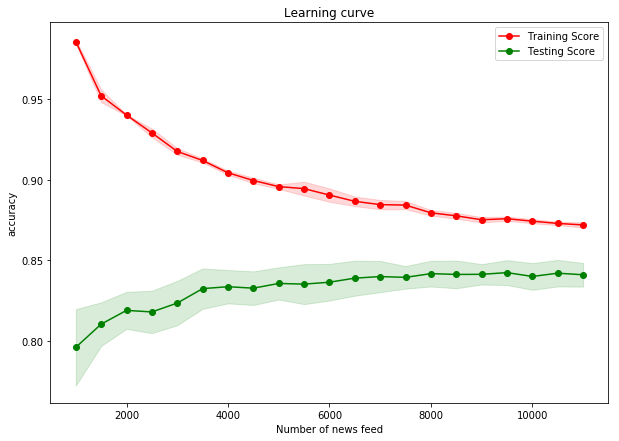

In [41]:
# ploting
train_std = np.std(train_scores, axis = 1)
train_mean = np.mean(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

fig = plt.figure(figsize=(10,7))
plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
plt.fill_between(sizes, train_mean - train_std, \
                train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(sizes, test_mean - test_std, \
                test_mean + test_std, alpha = 0.15, color = 'g')
plt.xlabel("Number of news feed");
plt.ylabel("accuracy");
plt.legend();
plt.title("Learning curve");

## 15- upcomming works
The model can be enhanced by 1. better tagging of the data 2. tuning parameters using GridSearch 3. trying other ML algorithems like NN and CNN